In [1]:
DATE = "2021-09-15"
TASK = "sequencing-saturation"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-09-15-sequencing-saturation"

In [163]:
import Pkg
pkgs = [
    "BioAlignments",
    "BioSequences",
    "Clustering",
    "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
    "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
#     "Distributions",
#     "EzXML",
    "FASTX",
#     "GFF3",
    "GLM",
    "GraphPlot",
#     "HTTP",
#     "Impute",
#     "JSON",
    "Graphs",
    "LsqFit",
#     "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
    "OnlineStats",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
function kmer_index_and_orientation_to_kmer(graph, kmer_index, orientation)
    kmer = graph.vprops[kmer_index][:kmer]
    if !orientation
        kmer = BioSequences.reverse_complement(kmer)
    end
    return kmer
end

kmer_index_and_orientation_to_kmer (generic function with 1 method)

In [4]:
function determine_edge_probabilities(graph)
    nv = Graphs.nv(graph)
    edge_probabilities = SparseArrays.spzeros(nv, nv)
    for v in 1:nv
        neighbors = Graphs.neighbors(graph, v)
        @assert issorted(neighbors)
        likelihoods = zeros(length(neighbors))
        for (i, neighbor) in enumerate(neighbors)
            if v <= neighbor
                edge = Graphs.Edge(v, neighbor)
            else
                edge = Graphs.Edge(neighbor, v)
            end
            @assert Graphs.has_edge(graph, edge)
            likelihoods[i] = graph.eprops[edge][:count]     
        end
        likelihoods = likelihoods ./ sum(likelihoods)
#         @show likelihoods
#         @show neighbors
        for (neighbor, likelihood) in zip(neighbors, likelihoods)
            edge_probabilities[v, neighbor] = likelihood
        end
    end
    
    for source in 1:size(edge_probabilities, 1)
        destinations = findall(edge_probabilities[source, :] .> 0)
        destination_counts = [graph.vprops[dest][:count] for dest in destinations]
        destination_likelihoods = destination_counts ./ sum(destination_counts)
        for (dest, likelihood) in zip(destinations, destination_likelihoods)
            edge_probabilities[source, dest] *= likelihood
        end
        edge_probabilities[source, :] ./= sum(edge_probabilities[source, :])
        @assert abs(1-sum(edge_probabilities[source, :])) <= eps(Float64)
    end
    
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [5]:
function orient_path(graph, kmers, path, opening_orientation, opening_kmer, closing_orientation)
    vertices = path
    path_orientations = [opening_orientation]
    path_kmers = [opening_kmer]
    @show opening_orientation
    for (i, vertex) in enumerate(vertices[2:end])
        @show i, vertex, last(path_orientations)
        viable_neighbors = typeof(opening_kmer)[]
        viable_neighbor = nothing
        viable_orientations = Bool[]
        viable_orientation = nothing
        for neighbor in BioSequences.neighbors(last(path_kmers))
            @show "considering going from $(last(path_kmers)) to $(neighbor)"
#             @show "considering going from $(last(path_kmers)) to $(neighbor)"
            canonical_neighbor = BioSequences.canonical(neighbor)
            canonical_neighbor_index_range = searchsorted(kmers, canonical_neighbor)
#             @show canonical_neighbor_index_range
            if length(canonical_neighbor_index_range) == 1
                @show canonical_neighbor_index = first(canonical_neighbor_index_range)
                if canonical_neighbor_index == vertex
                    @show "hit, selecting $neighbor"
                    viable_neighbor = neighbor
                    viable_orientation = neighbor == canonical_neighbor
                end
            end
        end
        if (viable_neighbor != nothing) && (viable_orientation != nothing)
            push!(path_kmers, viable_neighbor)
            push!(path_orientations, viable_orientation)
        else
            return nothing
            # not a viable path, need to look towards the next miss
        end
    end
    return vertices, path_orientations, path_kmers
end

orient_path (generic function with 1 method)

In [6]:
function take_a_walk(graph, edge_likelihoods, kmers, kmer, walk_length)
    walk = [kmer]
    current_kmer_indices = searchsorted(kmers, BioSequences.canonical(last(walk)))
    @assert length(current_kmer_indices) == 1
    current_kmer_index = first(current_kmer_indices)
    while length(walk) < walk_length
        viable_neighbors = Tuple{Int, Bool}[]
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_is_canonical = neighbor == canonical_neighbor
            neighbor_vertex_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_vertex_range)
                neighbor_vertex = first(neighbor_vertex_range)
                if Graphs.has_edge(graph, current_kmer_index, neighbor_vertex)
                    push!(viable_neighbors, (neighbor_vertex, neighbor_is_canonical))
                end
            end
        end
        if isempty(viable_neighbors)
            return walk
        elseif length(viable_neighbors) == 1
            chosen_neighbor = first(viable_neighbors)
        else
            viable_neighbor_indices = first.(viable_neighbors)
            step_likelihoods = StatsBase.weights(edge_likelihoods[current_kmer_index, viable_neighbor_indices])
            chosen_neighbor = StatsBase.sample(viable_neighbors, step_likelihoods)
        end
        kmer = kmer_index_and_orientation_to_kmer(graph, chosen_neighbor...)
        push!(walk, kmer)
        current_kmer_indices = searchsorted(kmers, BioSequences.canonical(last(walk)))
        @assert length(current_kmer_indices) == 1
        current_kmer_index = first(current_kmer_indices)
    end
    return walk
end

take_a_walk (generic function with 1 method)

In [7]:
"""
    sort_fastq(input_fastq, output_fastq)

This turns a 4-line FASTQ entry into a single tab separated line,
adds a column with the length of each read, passes it to Unix sort,
removes the length column, and converts it back into a FASTQ file.

sorts longest to shortest!!

http://thegenomefactory.blogspot.com/2012/11/sorting-fastq-files-by-sequence-length.html
"""
function sort_fastq(input_fastq, output_fastq="")
    
    if endswith(input_fastq, ".gz")
        p = pipeline(
                `gzip -dc $input_fastq`,
                `paste - - - -`,
                `perl -ne '@x=split m/\t/; unshift @x, length($x[1]); print join "\t",@x;'`,
                `sort -nr`,
                `cut -f2-`,
                `tr "\t" "\n"`,
                `gzip`
                )
    else
        p = pipeline(
                `cat $input_fastq`,
                `paste - - - -`,
                `perl -ne '@x=split m/\t/; unshift @x, length($x[1]); print join "\t",@x;'`,
                `sort -nr`,
                `cut -f2-`,
                `tr "\t" "\n"`
                )
    end
    run(pipeline(p, output_fastq))
    return output_fastq
end

sort_fastq

In [8]:
function count_reads(fastq_file)
    @info "determing # of reads in fastq file"
    n_reads = 0
    for record in Mycelia.open_fastx(fastq_file)
        n_reads += 1
    end
    @show n_reads
    return n_reads
end

count_reads (generic function with 1 method)

In [9]:
function determine_read_lengths(fastq_file; total_reads = Inf)
    if total_reads == Inf
        total_reads = count_reads(fastq_file)
    end
    read_lengths = zeros(Int, total_reads)
    @info "determining read lengths"
    p = ProgressMeter.Progress(total_reads, 1)
    for (i, record) in enumerate(Mycelia.open_fastx(fastq_file))
#         push!(read_lengths, length(FASTX.sequence(record)))
        read_lengths[i] = length(FASTX.sequence(record))
        ProgressMeter.next!(p)
    end
    return read_lengths
end

determine_read_lengths (generic function with 1 method)

In [10]:
function max_canonical_kmers(kmer_type)
    k_size = last(kmer_type.parameters)
    # we only consider canonical kmers so cut in 1/2
    max_canonical_kmers = Int(4^k_size / 2)
    return max_canonical_kmers
end

max_canonical_kmers (generic function with 1 method)

In [79]:
function assess_kmer_saturation(fastq_file, kmer_type; kmers_to_assess=Inf, power=10)
    canonical_kmers = Set{kmer_type}()
    
    max_possible_kmers = max_canonical_kmers(kmer_type)
    
    if kmers_to_assess == Inf
        kmers_to_assess = max_possible_kmers
    end
    
    sampling_points = Int[0]
    i = 0
    while power^i <= kmers_to_assess
        push!(sampling_points, power^i)
        i += 1
    end
    
    unique_kmer_counts = zeros(Int, length(sampling_points))
    
    if length(sampling_points) < 3
        @info "increase the # of reads analyzed or decrease the power to acquire more data points"
        return (;sampling_points, unique_kmer_counts)
    end
    
    p = ProgressMeter.Progress(kmers_to_assess, 1)
    
    kmers_assessed = 0
    for record in Mycelia.open_fastx(fastq_file)
        for kmer in BioSequences.each(kmer_type, FASTX.sequence(record))
            unique_kmers_count = length(canonical_kmers)
            if (kmers_assessed == kmers_to_assess) || (unique_kmers_count == max_possible_kmers)
                sampling_points = vcat(filter(s -> s < kmers_assessed, sampling_points), [kmers_assessed])
                unique_kmer_counts = vcat(unique_kmer_counts[1:length(sampling_points)-1], [unique_kmers_count])
                return (;sampling_points, unique_kmer_counts)
            elseif rem(log(power, kmers_assessed), 1) == 0.0
                i = findfirst(sampling_points .== kmers_assessed)
                unique_kmer_counts[i] = unique_kmers_count
                percent_saturation = round(unique_kmers_count/max_possible_kmers, sigdigits=5) * 100
#                 @show kmers_assessed, percent_saturation
            end
            canonical_kmer = kmer.fw < kmer.bw ? kmer.fw : kmer.bw
            push!(canonical_kmers, canonical_kmer)
            kmers_assessed += 1
            ProgressMeter.next!(p)
        end
    end
    return (;sampling_points, unique_kmer_counts)
end

assess_kmer_saturation (generic function with 1 method)

In [159]:
function add_edge_to_graph(graph, edge_mer, kmers)
    edge = BioSequences.LongDNASeq(edge_mer.fw)
#     canonical_src = BioSequences.DNAMer{k}(BioSequences.canonical!(edge[1:end-1]))
#     canonical_dst = BioSequences.DNAMer{k}(BioSequences.canonical!(edge[2:end]))

    canonical_src = BioSequences.canonical(BioSequences.DNAMer{k}(edge[1:end-1]))
    
    src_index_range = searchsorted(kmers, canonical_src)
    if isempty(src_index_range)
        return
    else
        @assert length(src_index_range) == 1
    end
    src_index = first(src_index_range)

    canonical_dst = BioSequences.canonical(BioSequences.DNAMer{k}(edge[2:end]))
    dst_index_range = searchsorted(kmers, canonical_dst)
    if isempty(dst_index_range)
        return
    else
        @assert length(dst_index_range) == 1
    end
    dst_index = first(dst_index_range)
    graph_edge = Graphs.Edge(src_index, dst_index)
    Graphs.add_edge!(graph, graph_edge)
end

add_edge_to_graph (generic function with 1 method)

In [12]:
# Michaelis–Menten
function calculate_v(s,p)
    vmax = p[1]
    km = p[2]
    v = (vmax .* s) ./ (km .+ s)
    return v
end

calculate_v (generic function with 1 method)

In [13]:
# read in reads from pacbio run

In [14]:
# fastq_directory = "$(homedir())/pacbio-test-data"
# fastq_file = first(readdir(fastq_directory, join=true))
fastq_file = "$(homedir())/pacbio-test-data/b002225.subreads.fastq.gz"

"/home/jovyan/pacbio-test-data/b002225.subreads.fastq.gz"

In [15]:
# sort fastq file from shortest to longest reads

In [16]:
sorted_fastq_file = replace(fastq_file, r"\.fastq\.gz$" => ".sorted.fastq.gz")
# @time sort_fastq(fastq_file, sorted_fastq_file)
# 62 minutes!

"/home/jovyan/pacbio-test-data/b002225.subreads.sorted.fastq.gz"

In [ ]:
# @time total_reads = count_reads(sorted_fastq_file)
# total_reads = 1970799

In [ ]:
# @time read_lengths = determine_read_lengths(sorted_fastq_file, total_reads = total_reads)

In [17]:
power = 2

2

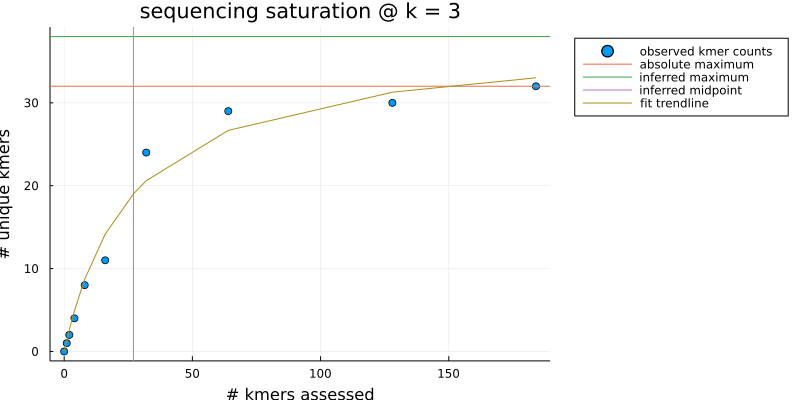

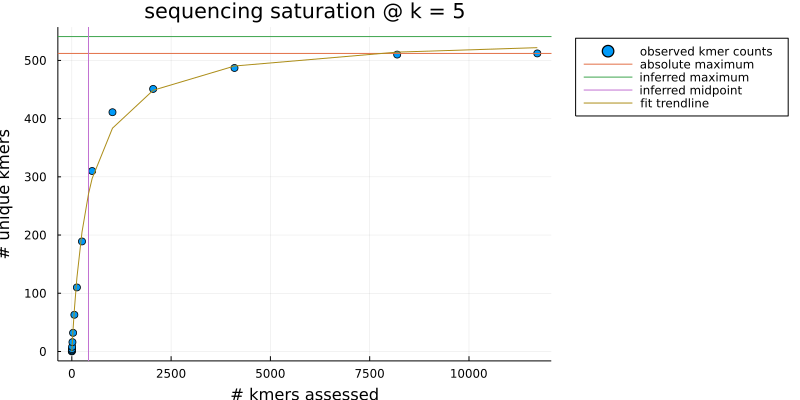

  0.000164 seconds (274 allocations: 32.141 KiB)
(k, predicted_saturation) = (3, 1.1875)
  0.000212 seconds (252 allocations: 36.047 KiB)
(k, predicted_saturation) = (5, 1.056640625)


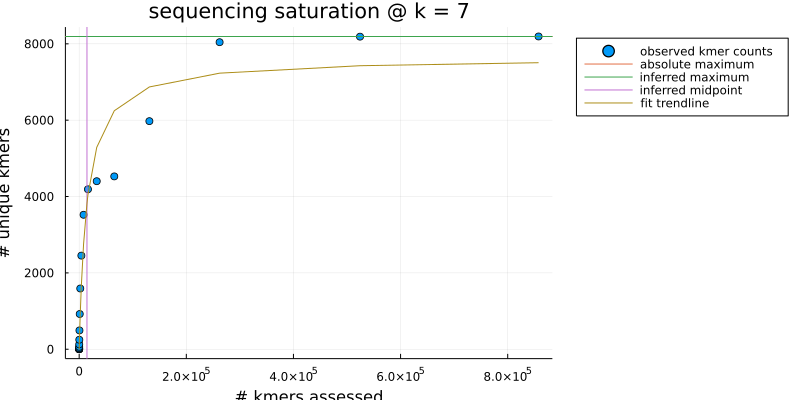

  0.000147 seconds (472 allocations: 81.391 KiB)
(k, predicted_saturation) = (7, 1.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


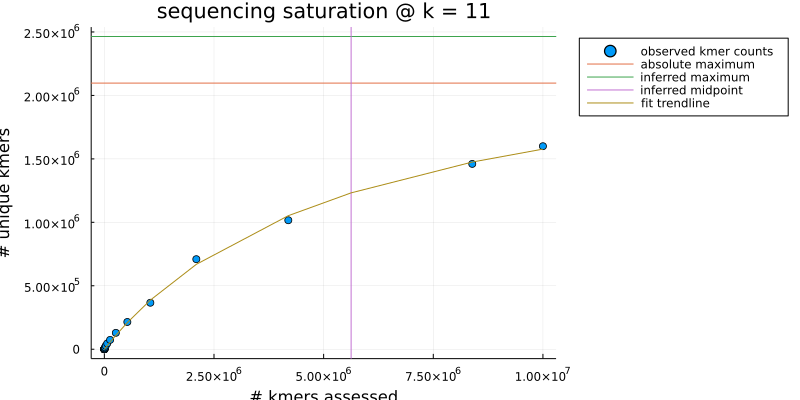

  0.000109 seconds (283 allocations: 52.391 KiB)
(k, predicted_saturation) = (11, 1.1751065254211426)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


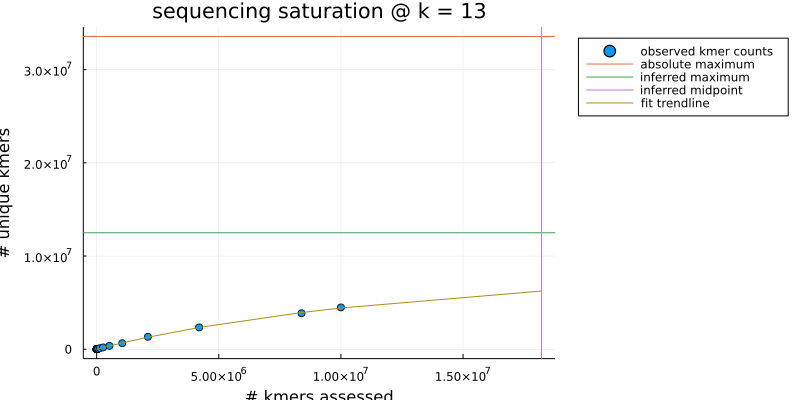

  0.000139 seconds (305 allocations: 56.672 KiB)
(k, predicted_saturation) = (13, 0.3723829388618469)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


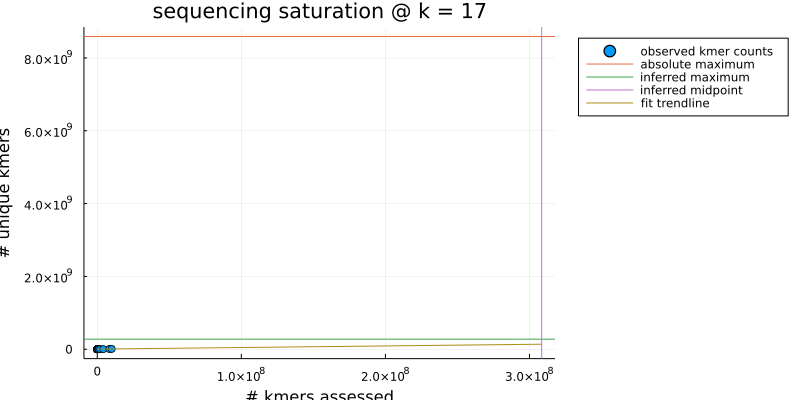

  0.000151 seconds (406 allocations: 76.953 KiB)
(k, predicted_saturation) = (17, 0.03227968467399478)


In [80]:
ks = Primes.primes(3, 31)
minimum_k = first(ks)
minimum_saturation = Inf
midpoint = Inf
for k in ks
    kmer_type = BioSequences.DNAMer{k}
#     kmers_per_read = read_lengths .- k .+ 1
#     total_kmers = sum(kmers_per_read)
#     kmers_to_assess = minimum([10_000_000, max_canonical_kmers(kmer_type), Int(ceil(total_kmers * .01))])
#     kmers_to_assess = minimum([10_000_000, max_canonical_kmers(kmer_type)])
    kmers_to_assess = 10_000_000
    sampling_points, kmer_counts = assess_kmer_saturation(sorted_fastq_file, kmer_type, kmers_to_assess=kmers_to_assess, power=power)
    observed_midpoint_index = findfirst(i -> kmer_counts[i] > last(kmer_counts)/2, 1:length(sampling_points))
    observed_midpoint = sampling_points[observed_midpoint_index]
    initial_parameters = Float64[maximum(kmer_counts), observed_midpoint]
    @time fit = LsqFit.curve_fit(calculate_v, sampling_points, kmer_counts, initial_parameters)
    inferred_kmer_count = max(Int(ceil(fit.param[1])), last(kmer_counts))
    inferred_midpoint = Int(ceil(fit.param[2]))
    predicted_saturation = inferred_kmer_count / max_canonical_kmers(kmer_type)
    @show k, predicted_saturation
    
    p = StatsPlots.scatter(
        sampling_points,
        kmer_counts,
        label="observed kmer counts",
        ylabel="# unique kmers",
        xlabel="# kmers assessed",
        title = "sequencing saturation @ k = $k",
        legend=:outertopright,
        size=(800, 400)
        )
    StatsPlots.hline!(p, [max_canonical_kmers(kmer_type)], label="absolute maximum")
    StatsPlots.hline!(p, [inferred_kmer_count], label="inferred maximum")
    StatsPlots.vline!(p, [inferred_midpoint], label="inferred midpoint")
    # xs = vcat(sampling_points, [last(sampling_points) * 2^i for i in 1:2])
    xs = sort([sampling_points..., inferred_midpoint])
    ys = calculate_v(xs, fit.param)
    StatsPlots.plot!(
        p,
        xs,
        ys,
        label="fit trendline")
    display(p)
    
    if predicted_saturation < minimum_saturation
        minimum_saturation = predicted_saturation
        minimum_k = k
        midpoint = inferred_midpoint 
    end
    if predicted_saturation < 0.1
        break
    end
end

In [23]:
kmers_to_write = midpoint

308489360

In [20]:
k = minimum_k

17

In [21]:
kmer_type = BioSequences.DNAMer{k}
# kmers_per_read = read_lengths .- k .+ 1
# total_kmers = sum(kmers_per_read)

BioSequences.DNAMer{17} (alias for BioSequences.Mer{BioSequences.DNAAlphabet{2}, 17})

In [ ]:
# n_kmers = 0
# reads_to_write = 0
# for (i, kmers_in_read) in enumerate(kmers_per_read)
#     n_kmers += kmers_in_read
# #     if n_kmers > (midpoint * 2)
#     if n_kmers > (midpoint)
#         @show reads_to_write = i
#         break
#     end
# end

In [ ]:
# downsample reads to desired depth

In [22]:
subset_fastq_file = replace(sorted_fastq_file, ".sorted.fastq.gz" => ".sorted.subset.fastq.gz")
# @time sort_fastq(fastq_file, sorted_fastq_file)
# 62 minutes!

"/home/jovyan/pacbio-test-data/b002225.subreads.sorted.subset.fastq.gz"

In [24]:
io = CodecZlib.GzipCompressorStream(open(subset_fastq_file, "w"))
fastx_io = FASTX.FASTQ.Writer(io)
kmers_written = 0
for (i, record) in enumerate(Mycelia.open_fastx(sorted_fastq_file))
    for kmer in BioSequences.each(kmer_type, FASTX.sequence(record))
        kmers_written += 1
    end
    write(fastx_io, record)
    if kmers_written >= kmers_to_write
        @info "$i records written"
        break
    end
end
close(fastx_io)
close(io)

┌ Info: 8452 records written
└ @ Main In[24]:10


In [25]:
determine_read_lengths(subset_fastq_file)

┌ Info: determing # of reads in fastq file
└ @ Main In[8]:2


n_reads = 8452


┌ Info: determining read lengths
└ @ Main In[9]:6
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


8452-element Vector{Int64}:
 121182
 108569
 108380
 107958
 107427
 106462
 106381
 105472
 105019
 103842
 103738
 103467
 102997
      ⋮
  24653
  24653
  24652
  24651
  24651
  24651
  24650
  24650
  24647
  24645
  24645
  24644

In [ ]:
# plot kmer spectra frequency

In [98]:
# 691.364224 seconds
@time kmer_counts = Mycelia.count_canonical_kmers(kmer_type, subset_fastq_file)

822.253459 seconds (1.03 M allocations: 28.390 GiB, 44.91% gc time, 0.06% compilation time)


OrderedCollections.OrderedDict{BioSequences.DNAMer{17}, Int64} with 220415426 entries:
  AAAAAAAAAAAAAAAAA => 784095
  AAAAAAAAAAAAAAAAC => 20879
  AAAAAAAAAAAAAAAAG => 12745
  AAAAAAAAAAAAAAAAT => 24195
  AAAAAAAAAAAAAAACA => 18587
  AAAAAAAAAAAAAAACC => 3279
  AAAAAAAAAAAAAAACG => 884
  AAAAAAAAAAAAAAACT => 1068
  AAAAAAAAAAAAAAAGA => 11241
  AAAAAAAAAAAAAAAGC => 535
  AAAAAAAAAAAAAAAGG => 1879
  AAAAAAAAAAAAAAAGT => 715
  AAAAAAAAAAAAAAATA => 22413
  AAAAAAAAAAAAAAATC => 1137
  AAAAAAAAAAAAAAATG => 839
  AAAAAAAAAAAAAAATT => 2981
  AAAAAAAAAAAAAACAA => 18081
  AAAAAAAAAAAAAACAC => 1804
  AAAAAAAAAAAAAACAG => 476
  AAAAAAAAAAAAAACAT => 682
  AAAAAAAAAAAAAACCA => 1695
  AAAAAAAAAAAAAACCC => 1722
  AAAAAAAAAAAAAACCG => 299
  AAAAAAAAAAAAAACCT => 275
  AAAAAAAAAAAAAACGA => 471
  ⋮                 => ⋮

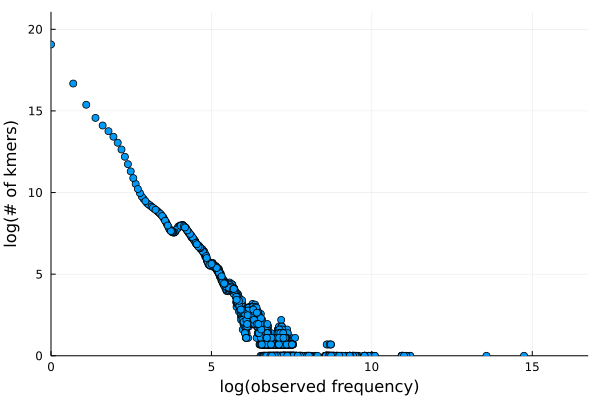

In [32]:
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts))

In [83]:
kmer_counts_histogram = StatsBase.countmap(values(kmer_counts))

Dict{Int64, Int64} with 26 entries:
  8714485 => 1
  16      => 1
  8       => 1
  866463  => 1
  1       => 1
  256     => 1
  0       => 1
  32      => 1
  1024    => 1
  127317  => 1
  4069    => 1
  512     => 1
  16272   => 1
  64      => 1
  3771548 => 1
  468801  => 1
  8126    => 1
  128     => 1
  64445   => 1
  237085  => 1
  1855309 => 1
  4       => 1
  2       => 1
  7317485 => 1
  2043    => 1
  32571   => 1

In [92]:
base = 2

2

In [117]:
maximum_kmer_count = maximum(values(kmer_counts))

2527570

In [118]:
maximum_power = Int(floor(log(2, maximum_kmer_count)))

21

In [119]:
assembly_thresholds = [2^i for i in maximum_power:-1:0]

22-element Vector{Int64}:
 2097152
 1048576
  524288
  262144
  131072
   65536
   32768
   16384
    8192
    4096
    2048
    1024
     512
     256
     128
      64
      32
      16
       8
       4
       2
       1

In [182]:
# assembly_threshold = assembly_thresholds[11]
assembly_threshold = assembly_thresholds[6]

65536

In [183]:
filtered_kmer_counts = filter(x -> x[2] >= assembly_threshold, kmer_counts)

OrderedCollections.OrderedDict{BioSequences.DNAMer{17}, Int64} with 4 entries:
  AAAAAAAAAAAAAAAAA => 784095
  ACCCCCCCCCCCCCCCC => 72276
  CCCCCCCCCCCCCCCCA => 72955
  CCCCCCCCCCCCCCCCC => 2527570

In [184]:
K = length(keys(filtered_kmer_counts))

4

In [185]:
# create an undirected kmer graph from the sequence

In [186]:
graph = MetaGraphs.MetaGraph(K)
# graph = Graphs.SimpleGraph(K)

{4, 0} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [187]:
ProgressMeter.@showprogress for (i, (kmer, count)) in enumerate(filtered_kmer_counts)
#     @show i, kmer, count
    MetaGraphs.set_prop!(graph, i, :kmer, kmer)
    MetaGraphs.set_prop!(graph, i, :count, count)
end

In [188]:
kmers = collect(keys(filtered_kmer_counts))

4-element Vector{BioSequences.DNAMer{17}}:
 AAAAAAAAAAAAAAAAA
 ACCCCCCCCCCCCCCCC
 CCCCCCCCCCCCCCCCA
 CCCCCCCCCCCCCCCCC

In [192]:
p = ProgressMeter.Progress(8452, 1)
# 50 minutes
# 40 minutes
# 0:09:51!
for record in Mycelia.open_fastx(subset_fastq_file)
    for edge_mer in BioSequences.each(BioSequences.DNAMer{k+1}, FASTX.sequence(record))
        add_edge_to_graph(graph, edge_mer, kmers)
    end
    ProgressMeter.next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:51


In [193]:
graph

{4, 5} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [194]:
# how many connected components?
connected_components = length(Graphs.connected_components(graph))

2

In [195]:
# average connectedness
OnlineStats.fit!(OnlineStats.Mean(), Graphs.neighbors(graph, v) for v in Graphs.vertices(graph))

Mean: n=8 | value=2.875

In [199]:
number_of_connected_components = [
    1,
    1,
    2,
    2,
    2,
    2
]

6-element Vector{Int64}:
 1
 1
 2
 2
 2
 2

In [201]:
mean_connectivity_values = Any[
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    2.875
]

6-element Vector{Any}:
 1.0
 1.0
 1.0
 1.0
 1.0
 2.875

In [ ]:
for i in 7:17
    @show i
    assembly_threshold = assembly_thresholds[i]
    @show assembly_threshold
    
    filtered_kmer_counts = filter(x -> x[2] >= assembly_threshold, kmer_counts)
    K = length(keys(filtered_kmer_counts))
    @show K
    graph = MetaGraphs.MetaGraph(K)
    for (i, (kmer, count)) in enumerate(filtered_kmer_counts)
        MetaGraphs.set_prop!(graph, i, :kmer, kmer)
        MetaGraphs.set_prop!(graph, i, :count, count)
    end

    kmers = collect(keys(filtered_kmer_counts))

    p = ProgressMeter.Progress(8452, 1)
    for record in Mycelia.open_fastx(subset_fastq_file)
        for edge_mer in BioSequences.each(BioSequences.DNAMer{k+1}, FASTX.sequence(record))
            add_edge_to_graph(graph, edge_mer, kmers)
        end
        ProgressMeter.next!(p)
    end

    # how many connected components?
    connected_components = length(Graphs.connected_components(graph))
    @show connected_components
    @show push!(number_of_connected_components, connected_components)

    # average connectedness
    fit_mean = OnlineStats.fit!(OnlineStats.Mean(), Graphs.neighbors(graph, v) for v in Graphs.vertices(graph))
    @show fit_mean
    @show push!(mean_connectivity_values, fit_mean)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:14:57
Progress: 100%|█████████████████████████████████████████| Time: 0:15:02
Progress: 100%|█████████████████████████████████████████| Time: 0:15:06
Progress: 100%|█████████████████████████████████████████| Time: 0:15:12
Progress: 100%|█████████████████████████████████████████| Time: 0:15:17
Progress: 100%|█████████████████████████████████████████| Time: 0:15:15
Progress: 100%|█████████████████████████████████████████| Time: 0:15:25
Progress:  50%|████████████████████▌                    |  ETA: 0:09:18m

In [ ]:
alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), observation, genome)

In [ ]:
reverse_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), BioSequences.reverse_complement(observation), genome)

In [ ]:
if reverse_alignment.value < alignment.value
    observation = BioSequences.reverse_complement(observation)
    alignment = reverse_alignment
    @show "flipping"
end

In [ ]:
# convert genome into stranded path

In [ ]:
# function sequence_to_
observation_as_oriented_kmers = []
observation_kmers = collect(BioSequences.each(BioSequences.BigDNAMer{k}, observation))

In [ ]:
genome_kmers

In [ ]:
is_canonical = falses(length(observation_kmers))
kmer_index = zeros(Int, length(observation_kmers))
for (i, kmer) in enumerate(observation_kmers)
#     is_canonical[i] = kmer.fw <= kmer.bw
    canonical_kmer = BioSequences.canonical(kmer.fw)
    is_canonical[i] = kmer.fw == canonical_kmer
    kmer_index_range = searchsorted(kmers, canonical_kmer)
    if length(kmer_index_range) > 1
        @error "bad"
    elseif isempty(kmer_index_range)
        # do nothing, index is 0 to indicate not found
    else
        kmer_index[i] = first(kmer_index_range)
    end
end

In [ ]:
is_canonical

In [ ]:
kmer_index

In [ ]:
proposed_path = BioSequences.BigDNAMer{k}[]
opening_missing_kmer_path_index = findfirst(x -> x == 0, kmer_index)

# read is solid!
if opening_missing_kmer_path_index == nothing
#     proposed_seq = observation
    proposed_path = [kmer.fw for kmer in observation_kmers]
    @show "perfect read"
elseif all(index -> index == 0, kmer_index)
    @show "read is trash"
    # generate a new read from the assembly to replace this one

    observation_path_length = length(observation_kmers)
    proposed_path = nothing
    proposed_path_size_discrepancy = Inf
    starting_kmer_indices = StatsBase.sample(1:Graphs.nv(graph), min(10, Graphs.nv(graph)), replace=false)
    for starting_kmer_index in starting_kmer_indices
        starting_kmer_index = rand(1:Graphs.nv(graph))
        @show starting_kmer_index
        starting_kmer = graph.vprops[starting_kmer_index][:kmer]
        if rand(Bool)
            starting_kmer = BioSequences.reverse_complement(starting_kmer)
        end
        candidate_path = take_a_walk(graph, edge_likelihoods, kmers, starting_kmer, observation_path_length)
        discrepancy = abs(length(candidate_path) - observation_path_length)
        @show discrepancy
        if discrepancy < proposed_path_size_discrepancy
            proposed_path = candidate_path
            proposed_path_size_discrepancy = discrepancy
            if proposed_path_size_discrepancy == 0
                break
            end
        end
    end
else
    if opening_missing_kmer_path_index == 1
        opening_solid_kmer = nothing
    #     closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
    elseif opening_missing_kmer_path_index != nothing
        opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
        opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
    end

    if opening_missing_kmer_path_index == nothing
        closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), 1)
    else
        closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
    end
    if closing_solid_kmer_path_index == nothing
        @show "end is open"
        closing_solid_kmer = nothing
    else
        closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
    end


    extensions = 0
    while (opening_missing_kmer_path_index != nothing) && (extensions < 5)
        extensions += 1
        @show extensions

        if (opening_solid_kmer == nothing) && (closing_solid_kmer != nothing)
            @show "missing opening"
            @show closing_solid_kmer
            inverted_closing_solid_kmer = BioSequences.reverse_complement(closing_solid_kmer)
            @show inverted_closing_solid_kmer
            walk_length = closing_solid_kmer_path_index
            chosen_walk = take_a_walk(graph, edge_likelihoods, kmers, inverted_closing_solid_kmer, walk_length)
            chosen_walk = reverse(BioSequences.reverse_complement.(chosen_walk))
            @show chosen_walk
            @show closing_solid_kmer_path_index
            @assert observation_kmers[closing_solid_kmer_path_index].fw == last(chosen_walk)
            proposed_path = chosen_walk
            opening_missing_kmer_path_index = findnext(map(x -> x == 0, kmer_index), closing_solid_kmer_path_index+1)

            if opening_missing_kmer_path_index == 1
                opening_solid_kmer = nothing
            elseif opening_missing_kmer_path_index != nothing
                need_to_add = getproperty.(observation_kmers[closing_solid_kmer_path_index+1:opening_missing_kmer_path_index-1], :fw)
                append!(proposed_path, need_to_add)
                opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
                opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
                closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
                if closing_solid_kmer_path_index == nothing
                    closing_solid_kmer = nothing
                else
                    closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                end
            end
        end

        if (opening_solid_kmer != nothing) && (closing_solid_kmer == nothing)
            @show "missing closing"
            walk_length = length(observation_kmers) - opening_solid_kmer_path_index+1
            chosen_walk = take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length)
            @show chosen_walk
            @assert observation_kmers[opening_solid_kmer_path_index].fw == first(chosen_walk)
            if isempty(proposed_path)
                proposed_path = getproperty.(observation_kmers[1:opening_solid_kmer_path_index], :fw)
            end
            append!(proposed_path, chosen_walk[2:end])
            opening_missing_kmer_path_index = nothing
        end

        while (opening_solid_kmer != nothing) && (closing_solid_kmer != nothing)
            @show "bubble!"
            opening_solid_kmer_index = kmer_index[opening_solid_kmer_path_index]
            closing_solid_kmer_index = kmer_index[closing_solid_kmer_path_index]

            @show opening_solid_kmer, opening_solid_kmer_path_index
            @show closing_solid_kmer, closing_solid_kmer_path_index
            @show length(proposed_path)
            
            #####################################################################################
            # DETERMINE PATH LENGTH
            #####################################################################################
            # by default, we're assuming that we want to walk the same distance as our bubble + 1
            bubble_path_length = closing_solid_kmer_path_index - opening_solid_kmer_path_index + 1

            if opening_solid_kmer_index != closing_solid_kmer_index
                path = Graphs.a_star(graph, opening_solid_kmer_index, closing_solid_kmer_index)
                normalized_path = Int[path[1].src, [edge.dst for edge in path]...]
                shortest_paths = [normalized_path]
            else
                neighbors = Graphs.neighbors(graph, opening_solid_kmer_index)
                shortest_paths = Vector{Vector{Int}}()
                for neighbor in neighbors
                    path = Graphs.a_star(graph, neighbor, closing_solid_kmer_index)
                    normalized_path = Int[path[1].src, [edge.dst for edge in path]...]
                    push!(shortest_paths, normalized_path)
                end
            end
            # but if our bubble is a deletion, then walking that length may not get us across to the other side
            # so we also determine the longest, shortest path
            longest_shortest_walk_length = maximum(length.(shortest_paths))


            longest_walk_length = max(bubble_path_length, longest_shortest_walk_length)
            walk_length = Int(ceil(longest_walk_length * 1.1))

            walks = Vector{Int}[]
            for i in 1:3
                println("round $i")
                walks = [take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length)]
                while allunique(walks)
                    push!(walks, take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length))
                end

                walks = filter(path -> closing_solid_kmer in path, walks)

                if isempty(walks)
                    walk_length = Int(ceil(walk_length * 1.1))
                else
                    # done!
                    break
                end
            end

            if !isempty(walks)
                candidate_paths = sort(collect(StatsBase.countmap(walks)), by=x->x[2], rev=true)
                selected_path = first(first(candidate_paths))
                selected_path_closing_solid_kmer_intersects = findall(kmer -> kmer == closing_solid_kmer, selected_path)
                if length(selected_path_closing_solid_kmer_intersects) > 1
                    @show "here"
                    selected_path_closing_solid_kmer_intersect = 0
                    d = Inf
                    for i in selected_path_closing_solid_kmer_intersects
                        candidate_distance = abs(i - walk_length)
                        if candidate_distance < d
                            d = candidate_distance
                            selected_path_closing_solid_kmer_intersect = i
                        end
                    end
                else
                    selected_path_closing_solid_kmer_intersect = first(selected_path_closing_solid_kmer_intersects)
                end
                selected_path = selected_path[1:selected_path_closing_solid_kmer_intersect]
                if isempty(proposed_path)
                    proposed_path = getproperty.(observation_kmers[1:opening_solid_kmer_path_index], :fw)
                end
                append!(proposed_path, selected_path[2:end])
                opening_missing_kmer_path_index = findnext(map(x -> x == 0, kmer_index), closing_solid_kmer_path_index+1)
                if opening_missing_kmer_path_index == nothing
                    #done
                    opening_solid_kmer = nothing
                elseif opening_missing_kmer_path_index == 1
                    # also done?
                    opening_solid_kmer = nothing
                elseif opening_missing_kmer_path_index != nothing
                    need_to_add = getproperty.(observation_kmers[closing_solid_kmer_path_index+1:opening_missing_kmer_path_index-1], :fw)
                    append!(proposed_path, need_to_add)
                    opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
                    opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
                    closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
                    if closing_solid_kmer_path_index == nothing
                        closing_solid_kmer = nothing
                    else
                        closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                    end
                end
            else
                @show "need to bump out"
                if opening_missing_kmer_path_index >= 2
                    opening_missing_kmer_path_index -= 1
                    opening_solid_kmer = nothing
                    # this should now break out to larger while loop
                end
                # push out closing node and try again
                closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), closing_solid_kmer_path_index+1)

                if closing_solid_kmer_path_index == nothing
                    @show "end is open"
                    closing_solid_kmer = nothing
                else
                    closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                end
            end
        end
    end
    if closing_solid_kmer_path_index != nothing
        append!(proposed_path, getproperty.(observation_kmers[closing_solid_kmer_path_index+1:end], :fw))
    end
end

In [ ]:
proposed_path

In [ ]:
proposed_seq = BioSequences.LongDNASeq(first(proposed_path))
for kmer in proposed_path[2:end]
    push!(proposed_seq, last(kmer))
end
proposed_seq

In [ ]:
new_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), proposed_seq, genome)

In [ ]:
reverse_new_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), BioSequences.reverse_complement(proposed_seq), genome)

In [ ]:
if reverse_new_alignment.value < new_alignment.value
#     observation = BioSequences.reverse_complement!(observation)
    new_alignment = reverse_new_alignment
    @show "flipping"
end

In [ ]:
if new_alignment.value <= alignment.value
    @show "newer is equivalent or better"
    @show new_alignment.value, alignment.value
else
    @show "newer is worse, keep original"
    @show new_alignment.value, alignment.value
end